In [1]:
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt

from src.CPQAOA import CP_QAOA
from src.Grid import Grid
from src.Chain import Chain
from src.Tools import (portfolio_metrics, 
                       min_cost_partition, 
                       get_qubo, 
                       normalized_cost, 
                       qubo_limits, 
                       check_qubo,
                       qubo_cost,
                       partitioned_averages)

In [68]:
# Number of Qubits 
N=9
# number of excitations
k=4
# RNG seed for reproducibility
seed=0
# alpha in: s^T*mu + alpha*(s^T*Covar*s)
alpha=0.5
# Nr. of layer repetitions
layers=2
# Maximal number of iterations for classical solver
max_iter=400
# Using next nearest neighbors (in 1D chain model)
w_next_nearest_neighbors = True


"""my_chain = Chain(N_qubits=N)
print(f' Qubit indices in chain: \n', my_chain.get_chain_indexing())
print(f'\n Corresponding Nearest Neighbor index pairs: \n', my_chain.get_NN_indices())
print(f'\n Corresponding Nearest Neighbor + Next Nearest index pairs: \n', my_chain.get_NNN_indices())
init_strat = np.array([0,1,0,1,0,1])
my_chain.set_initialization_strategy(strategy=init_strat)
print(f'\n Initialization strategy is: \n', my_chain.get_initialization_strategy())
print(f'\n Corresponding indices is: \n', my_chain.get_initialization_indices())"""

my_grid = Grid(Rows=3,Cols=3)
print(f' Qubit indices in grid: \n', my_grid.get_grid_indexing())
print(f'\n Corresponding Nearest Neighbor index pairs: \n', my_grid.get_NN_indices())
print(f'\n Corresponding Nearest Neighbor + Next Nearest index pairs: \n', my_grid.get_NNN_indices())
init_strat = np.array([[0,1,0],
                       [1,0,1],
                       [0,1,0]])
my_grid.set_initialization_strategy(strategy=init_strat)
print(f'\n Initialization strategy is: \n', my_grid.get_initialization_strategy())
print(f'\n Corresponding indices is: \n', my_grid.get_initialization_indices())

# Deciding between grid and 1d chain topology
my_topology = my_grid

 Qubit indices in grid: 
 [[0 1 2]
 [3 4 5]
 [6 7 8]]

 Corresponding Nearest Neighbor index pairs: 
 [(0, 3), (0, 1), (1, 4), (1, 2), (2, 5), (3, 6), (3, 4), (4, 7), (4, 5), (5, 8), (6, 7), (7, 8)]

 Corresponding Nearest Neighbor + Next Nearest index pairs: 
 [(0, 3), (0, 1), (1, 4), (1, 2), (2, 5), (3, 6), (3, 4), (4, 7), (4, 5), (5, 8), (6, 7), (7, 8), (0, 6), (0, 2), (1, 7), (2, 8), (3, 5), (6, 8)]

 Initialization strategy is: 
 [[0 1 0]
 [1 0 1]
 [0 1 0]]

 Corresponding indices is: 
 [1, 3, 5, 7]


In [69]:
# Generating random problem instance 
expected_returns, covariances = portfolio_metrics(n=N, seed=seed)

# Retrieving C_min, C_max and corresponding states for original portfolio problem
constrained_result, full_result, lmbda = min_cost_partition(nr_qubits=N,
                                                            k=k,
                                                            mu=expected_returns,
                                                            sigma=covariances,
                                                            alpha=alpha)

portfolio_subspace_max_cost, portfolio_subspace_min_cost, portfolio_subspace_min_state = constrained_result['c_max'], constrained_result['c_min'], constrained_result['s']
full_space_max_cost = full_result['c_max']
portfolio_subspace_min_state_str = ''.join([str(_) for _ in portfolio_subspace_min_state])
print(f"Min. cost portfolio (constrained subspace): {portfolio_subspace_min_cost}")
print("Optimal portfolio state (constrained subspace) is: |"+portfolio_subspace_min_state_str+">")

# Generating QUBO corresponding to current problem instance
Q, offset = get_qubo(mu=expected_returns,
                     sigma=covariances, 
                     alpha=alpha,
                     lmbda=lmbda+1e-8, # Adding small constant purposely
                     k=k)
QUBO_limits = qubo_limits(Q=Q,offset=offset)
qubo_min_cost, qubo_max_cost = QUBO_limits['c_min'], QUBO_limits['c_max']
qubo_min_state, qubo_max_state = QUBO_limits['min_state'], QUBO_limits['max_state']
check_qubo(QUBO_matrix=Q, QUBO_offset=offset, expected_returns=expected_returns, covariances=covariances, alpha=alpha, k=k)
qubo_min_state_str = ''.join([str(_) for _ in qubo_min_state])
print(f"Min. cost QUBO: {qubo_min_cost}")
print("Min. cost QUBO state is: |"+qubo_min_state_str+">")
print("Check that qubo min cost is same as portfolio min cost:")
print(qubo_min_cost, portfolio_subspace_min_cost)
print("Check that qubo max cost is at least portfolio max cost:")
print(qubo_max_cost, portfolio_subspace_max_cost)

# Generating instances of ansatz'
CP_z_phase_ansatz = CP_QAOA(N_qubits=N,
                 cardinality=k,
                 layers=layers,
                 topology=my_topology,
                 QUBO_matrix=Q,
                 with_next_nearest_neighbors=w_next_nearest_neighbors,
                 with_gradient=True,
                 with_z_phase=False)

Min. cost portfolio (constrained subspace): 9.23718596749721
Optimal portfolio state (constrained subspace) is: |000011011>
Min. cost QUBO: 9.237185967497197
Min. cost QUBO state is: |000011011>
Check that qubo min cost is same as portfolio min cost:
9.237185967497197 9.23718596749721
Check that qubo max cost is at least portfolio max cost:
305.77773425384987 20.163638363889262


In [70]:
# Choosing optimizer for scipy
available_methods = ['COBYLA', 'Nelder-Mead', 'BFGS']
optimizer_method = available_methods[0]

# Generating callback function for plotting
CP_z_phase_costs = [] # Normalized costs
CP_z_phase_probs = [] # probability of optimal state
CP_z_phase_most_probables = []
solver_costs=[]

def CP_z_phase_callback_function(x):
    _dict_ = CP_z_phase_ansatz.get_state_probabilities(flip_states=False)
    CP_z_phase_most_probables.append(list(_dict_.keys())[np.argmax(list(_dict_.values()))])
    # N.B. Normalizing w. respect to full space max cost
    _cost_ = normalized_cost(result=_dict_,
                             QUBO_matrix=Q,
                             QUBO_offset=offset,
                             max_cost=portfolio_subspace_max_cost, 
                             min_cost=qubo_min_cost)
    if portfolio_subspace_min_state_str in list(_dict_.keys()):
        CP_z_phase_probs.append(_dict_[portfolio_subspace_min_state_str])
    else:
        CP_z_phase_probs.append(0)
    CP_z_phase_costs.append(_cost_)
    

# Generating initial guess for rotation angles for CP_ansatz
np.random.seed(seed)
theta_min, theta_max = -2*np.pi, 2*np.pi
N_angles = layers * len(my_topology.get_NN_indices())
if w_next_nearest_neighbors:
    N_angles = layers * len(my_topology.get_NNN_indices())
CP_z_phase_theta_i = np.random.uniform(low=theta_min, high=theta_max, size=N_angles)
print(f"CP+Z-PHASE: {len(CP_z_phase_theta_i)}")    

CP+Z-PHASE: 36


In [71]:
CP_z_phase_res = sc.optimize.minimize(fun=CP_z_phase_ansatz.get_cost, 
                                      x0=CP_z_phase_theta_i,
                                      method=optimizer_method,
                                      options={'disp': False, 
                                               'maxiter': max_iter},
                                      callback=CP_z_phase_callback_function)
CP_z_phase_res

 message: Maximum number of function evaluations has been exceeded.
 success: False
  status: 2
     fun: -1.0994602930397233
       x: [ 7.941e-01  2.785e+00 ... -5.493e+00  2.850e+00]
    nfev: 400
   maxcv: 0.0

0.0026469286708630173 0.039406824935781


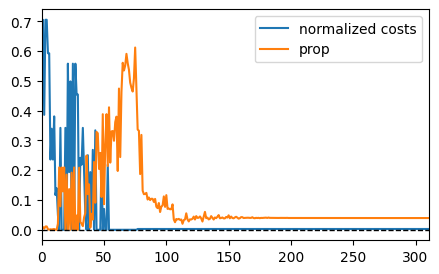

In [67]:
# N.B. Because the normalization is done w. respect to the "allowed states (w. k ones)" QAOA has cost above 1.
fig, ax = plt.subplots(1,1, figsize=(5,3))
ax.plot([it for it in range(len(CP_z_phase_costs))], CP_z_phase_costs, label='normalized costs')
ax.plot([it for it in range(len(CP_z_phase_probs))], CP_z_phase_probs, label='prop')

ax.set_xlim(0,len(CP_z_phase_costs))
ax.hlines(0,0,len(CP_z_phase_costs),lw=1,linestyles='dashed',colors='k')
ax.legend(loc='upper right')
print(CP_z_phase_costs[-1],CP_z_phase_probs[-1])
plt.show()

In [58]:
theta_opt = CP_z_phase_res.x
print(theta_opt)

[ 1.68999839  3.14275135  1.65427424  0.02795105 -0.83319722  1.57366894
 -0.76483247  5.36619599  5.87477614 -2.18282278  4.37973732  0.09026995
  0.70230181  5.57428936 -4.79413373 -4.0013809  -6.10862096  4.48459392
  4.67476473  4.5234882   6.11200649  3.63531703 -0.53526593  3.55279827
 -3.13426358  3.02011535 -4.68472416  6.20333894 -0.03813438 -1.03722129
 -3.10712137  3.13699291 -0.44667236  1.91361401 -6.43618357  1.17753088]


In [59]:
THETAS = list(theta_opt)
eps = 1e-6
counter = 1
facs = [float(i) for i in range(1,30)]
saved = []
for angle in THETAS:
    angle_is_pi = False
    for multiplicative_factor in facs:
        for divisor in facs:
            if np.abs(multiplicative_factor*np.pi/divisor-angle) <= eps and angle not in saved:
                print(f'theta_{counter}: {angle} is approx.: {int(multiplicative_factor)}*pi/{int(divisor)}')     
                counter += 1
                saved.append(angle)
                angle_is_pi = True
            elif np.abs(-multiplicative_factor*np.pi/divisor-angle) <= eps and angle not in saved:
                print(f'theta_{counter}: {angle} is approx.: -{int(multiplicative_factor)}*pi/{int(divisor)}')     
                counter += 1
                saved.append(angle)
                angle_is_pi = True
    if not angle_is_pi:
        counter +=1

In [40]:
# Generating instances of ansatz'
CP_test_ansatz= CP_QAOA(N_qubits=N,
                        cardinality=k,
                        layers=layers,
                        topology=my_topology,
                        QUBO_matrix=Q,
                        with_next_nearest_neighbors=True,
                        with_gradient=True,
                        with_z_phase=False)

In [51]:
print(theta_opt)

[ 5.49778712 -1.57079636  2.62445743 -3.14159262 -2.35619486  3.92699078
 -3.92699092 -0.48596359  4.71238868]


In [52]:
# populating things
_ = CP_test_ansatz.get_cost(angles=theta_opt)

In [53]:
np.linalg.norm(CP_test_ansatz.get_gradient(angles=theta_opt))

6.671853252990024e-06

In [54]:
print(CP_test_ansatz.get_gradient(angles=theta_opt))

[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -6.65209033e-06  3.90132874e-13 -6.30070364e-28  5.50784242e-21
  5.13147243e-07]
